In [ ]:
# Do not change the path of this notebook (do not use %cd)
# This is the updates version

# Prepare Enviroment

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
PATH_STORE_RESULTS = "/content/drive/MyDrive/MLDL_PROJECT/results/"

Mounted at /content/drive


In [ ]:
!pip install torchmetrics fvcore



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 115.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 91.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 62.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 44.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
!git clone https://github.com/MateusWiteck/domain_adaptation_semantic_segmentation.git


Cloning into 'domain_adaptation_semantic_segmentation'...
remote: Enumerating objects: 104, done.
remote: Counting objects: 100% (37/37), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 104 (delta 18), reused 16 (delta 8), pack-reused 67 (from 2)
Receiving objects: 100% (104/104), 1.34 MiB | 5.34 MiB/s, done.
Resolving deltas: 100% (41/41), done.


In [ ]:
%run domain_adaptation_semantic_segmentation/train.py

In [ ]:
# Download Citiescapes Dataset:
#!pip install -q gdown
#!gdown --id 1Qb4UrNsjvlU-wEsR9d7rckB0YS_LXgb2 --output Cityscapes.zip

# Copy from the drive
!cp /content/drive/MyDrive/MLDL_PROJECT/Cityscapes.zip /content/
!mkdir -p /content/domain_adaptation_semantic_segmentation/data

# Unzip
!unzip -q /content/Cityscapes.zip -d /content/domain_adaptation_semantic_segmentation/data/


In [ ]:
# Download GTA Dataset:
#!pip install -q gdown
#!gdown --id 1xYxlcMR2WFCpayNrW2-Rb7N-950vvl23 --output GTA5.zip

# Copy from Drive
!cp /content/drive/MyDrive/MLDL_PROJECT/GTA5.zip /content/
!mkdir -p /content/domain_adaptation_semantic_segmentation/data

# Unzip
!unzip -q /content/GTA5.zip -d /content/domain_adaptation_semantic_segmentation/data/


# Dataset and Dataloader

Here we should:
- Convert the GTA5 labels to the same format of the Cityscapes dataset (https://github.com/sarrrrry/PyTorchDL_GTA5/blob/master/pytorchdl_gta5/labels.py)
- Create the Datasets class for each one
- Create the DataLoader
- Define the train test division for the GTA dataset (Cityscapes is already defined)

## Cityscapes

/content/domain_adaptation_semantic_segmentation


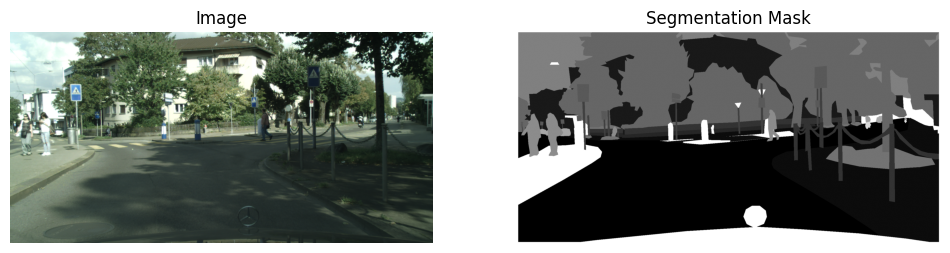

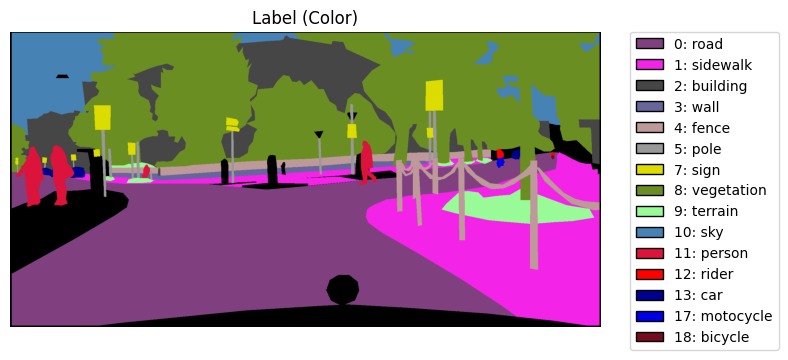

Dataset length: 1572
Image shape: torch.Size([3, 1024, 2048])
Label shape: torch.Size([1024, 2048])


<Figure size 640x480 with 0 Axes>

In [ ]:
%cd /content/domain_adaptation_semantic_segmentation/
%run datasets/cityscapes.py

## GTA5


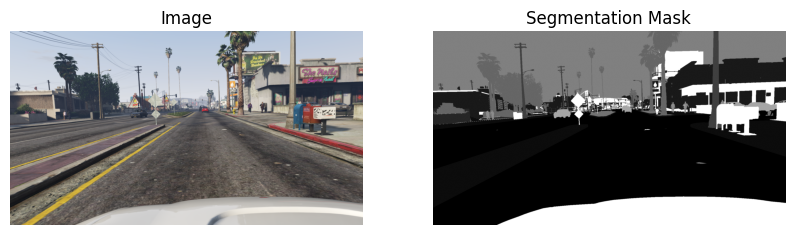

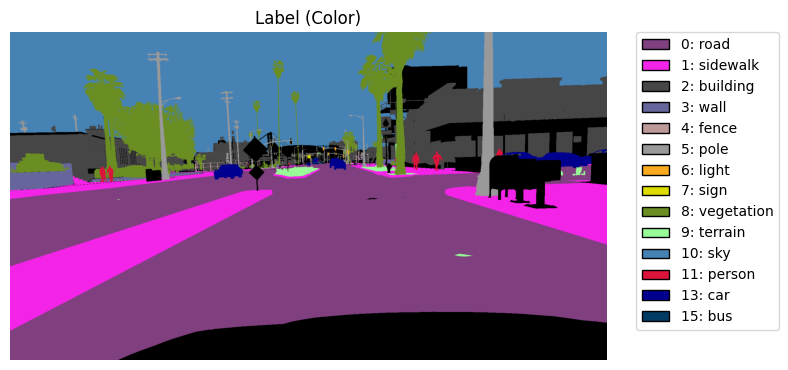

Dataset length: 2500
Image shape: torch.Size([3, 1052, 1914])
Label shape: torch.Size([1052, 1914])


<Figure size 640x480 with 0 Axes>

In [ ]:
%run datasets/gta5.py

# Task 3: DOMAIN SHIFT
From now on, we will employ BiSeNet as our segmentation to ease the resource requirements of the next experiments.
Consider as upper bound the results obtained in Table 2, i.e. the segmentation networks trained on the labeled target images (Cityscapes).


## A) Evaluating the domain shift problem in Semantic Segmentation
In semantic segmentation collecting manually annotated images is expensive. A popular solution consists in adopting synthetic datasets (i.e. artificial images generated in a simulation environment).

Specifically, in this step we employ the synthetic images from GTA5 [5] (source domain) to train our real-time segmentation network, which is then evaluated on the real images from Cityscapes [5] (target domain).

- Dataset: GTA5 [5]

- Training Set:  GTA5

- Validation Set: Cityscapes [5] validation split

- Training epochs: 50

- Training resolution (GTA5): 1280x720

- Test resolution (Cityscapes): 1024x512

- Backbone: ResNet18 (pre-trained on ImageNet) [2]

- Semantic Classes: 19

- Metrics: mIoU

In [ ]:

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms

# Set seed for reproducibility
torch.manual_seed(335079)

if torch.cuda.is_available():
    torch.device('cuda')
else:
    raise Exception('No GPU available')

# Clean the enviroment
torch.cuda.empty_cache()
torch.cuda.ipc_collect()


# ---------- Start TASK 2A ---------------------------

from datasets.cityscapes import CityScapes
from datasets.gta5 import GTA5
from models.bisenet.build_bisenet import BiSeNet
from torch.utils.data import random_split



# === Hyperparameters ===
num_classes = 19
batch_size = 8
num_workers = 2
learning_rate_cs = 2.5e-4
num_epochs = 50
training_resolution_gta = (720, 1280)
test_resolution = (512,1024)

# === Dataset & Dataloader ===
transform_gta = transforms.Compose([
    # Training resolution (Cityscapes): 1024x512
    transforms.Resize(training_resolution_gta, interpolation=transforms.InterpolationMode.NEAREST),  # TODO: explain what method the resize uses in the report.
    transforms.ToTensor(),
    transforms.Normalize(mean=[.485, .456, .406], std=[.229, .224, .225])
])
label_transform_gta = transforms.Resize(training_resolution_gta, interpolation=transforms.InterpolationMode.NEAREST) # Should be transformed as the image

# Train Val split on the GTA5 dataset
# Instantiate the dataset
dataset_gta = GTA5(root_dir='data/GTA5',
               transform=transform_gta,
               label_transform=label_transform_gta
)

# Compute lengths
total_size = len(dataset_gta)
train_size = int(0.8 * total_size)
val_size = total_size - train_size

# Split the dataset
train_dataset_gta, val_dataset_gta = random_split(dataset_gta, [train_size, val_size])

# Train Dataloader
dataloader_gta = DataLoader(
    train_dataset_gta,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True
)

# Validation dataset and dataloader
val_dataloader_gta = DataLoader(
    val_dataset_gta,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True
)

# Test dataset: Cityscapes
transform_cs = transforms.Compose([
    # Training resolution (Cityscapes): 1024x512
    transforms.Resize(test_resolution, interpolation=transforms.InterpolationMode.NEAREST),  # TODO: explain what method the resize uses in the report.
    transforms.ToTensor(),
    transforms.Normalize(mean=[.485, .456, .406], std=[.229, .224, .225])
])
label_transform_cs = transforms.Resize(test_resolution, interpolation=transforms.InterpolationMode.NEAREST) # Should be transformed as the image

test_dataset_cs = CityScapes(
    root_dir='data/Cityscapes/Cityspaces',
    split='val',
    transform=transform_cs,
    label_transform=label_transform_cs
)
test_dataloader_cs = DataLoader(
    test_dataset_cs,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True
)



In [ ]:

# === Model ===
# Load BISENET
bisenet_model = BiSeNet(num_classes=num_classes, context_path="resnet18").to('cuda')

# Optimizer
criterion = nn.CrossEntropyLoss(ignore_index=255)
bisenet_optimizer = optim.SGD(
    bisenet_model.parameters(),
    lr=learning_rate_cs,
    momentum=0.9,
    weight_decay=0.0005
)

# Train Model
metrics_train_task2b = train_model(
    bisenet_model,
    dataloader_gta,
    val_dataloader_gta,
    bisenet_optimizer,
    criterion,
    num_classes,
    num_epochs,
    "Task3a"
)

# === Save the model ===
torch.save(bisenet_model.state_dict(), PATH_STORE_RESULTS + 'final_models/task3a.pth')


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 225MB/s]
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:00<00:00, 198MB/s]


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: alessandro-gentile26 (mldl_project_2025) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch [1/50]


Epoch [2/50]


Epoch [3/50]


Epoch [4/50]


Epoch 4:  55%|█████▍    | 137/250 [10:11<09:30,  5.05s/it]

## B) Data augmentations to reduce the domain shift
A naive solution to improve the generalization capability of the segmentation network trained on the synthetic domain consists in the usage of data augmentations during training. Through them, we

i) virtually expand the dataset size and

ii) modify the visual appearance of source (synthetic) images in order to make them more similar to the target (real) ones.


Specifically, we repeat the previous experiment, introducing data augmentations at training time (e.g. horizontal flip, Gaussian Blur, Multiply, ecc.). The decision of what kind of algorithm is left to the student. Set the probability to perform augmentation to 0.5.

In [ ]:

!git pull
!git fetch --all
!ls